In [1]:
import h5py

import numpy as np
import torch 

import pyvista as pv
import pyvistaqt


pv.set_jupyter_backend('trame')

In [41]:
def print_structure(name, obj):
    if isinstance(obj, h5py.Dataset):
        print(f"Dataset: {name}, Shape: {obj.shape}, Data type: {obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"Group: {name}")

# Traverse the file structure
f.visititems(print_structure)

Group: sample_0000
Dataset: sample_0000/face, Shape: (20946, 3), Data type: int32
Dataset: sample_0000/inlet_idcs, Shape: (265,), Data type: int32
Dataset: sample_0000/pos, Shape: (10475, 3), Data type: float32
Dataset: sample_0000/pressure, Shape: (10475,), Data type: float32
Dataset: sample_0000/wss, Shape: (10475, 3), Data type: float32
Group: sample_0001
Dataset: sample_0001/face, Shape: (20548, 3), Data type: int32
Dataset: sample_0001/inlet_idcs, Shape: (271,), Data type: int32
Dataset: sample_0001/pos, Shape: (10276, 3), Data type: float32
Dataset: sample_0001/pressure, Shape: (10276,), Data type: float32
Dataset: sample_0001/wss, Shape: (10276, 3), Data type: float32
Group: sample_0002
Dataset: sample_0002/face, Shape: (18922, 3), Data type: int32
Dataset: sample_0002/inlet_idcs, Shape: (244,), Data type: int32
Dataset: sample_0002/pos, Shape: (9463, 3), Data type: float32
Dataset: sample_0002/pressure, Shape: (9463,), Data type: float32
Dataset: sample_0002/wss, Shape: (9463, 

In [4]:
import os
os.getcwd()

'/home/dema/Project/GAT/src/data_preprocessing'

In [3]:
path = '/home/dema/Project/GAT/datasets/original_datasets/single.hdf5'

In [4]:
with h5py.File(path, 'r') as f:
    data = {}
    
    # Loop through each sample group
    
    for i, sample in enumerate(f.keys()):
        sample_data = {}
        
        # Extract the datasets (wss, pressure, etc.) for each sample
        sample_data['wss'] = np.array(f[sample]['wss'])
        sample_data['pressure'] = np.array(f[sample]['pressure'])
        sample_data['pos'] = np.array(f[sample]['pos'])
        sample_data['face'] = np.array(f[sample]['face'])
        sample_data['inlet_idcs'] = np.array(f[sample]['inlet_idcs'])
        
        # Store the sample data in the dictionary
        data[i] = sample_data


In [12]:
with h5py.File(path, 'r') as f:
    data = {}
    
    # Loop through each sample group
    
    for i, sample in enumerate(f.keys()):
        sample_data = {}
        
        # Extract the datasets (wss, pressure, etc.) for each sample
        sample_data['wss'] = np.array(f[sample]['wss'])
        sample_data['pressure'] = np.array(f[sample]['pressure'])
        sample_data['pos'] = np.array(f[sample]['pos'])
        sample_data['face'] = np.array(f[sample]['face'])
        sample_data['inlet_idcs'] = np.array(f[sample]['inlet_idcs'])
        
        # Store the sample data in the dictionary
        data[i] = sample_data


len(data)

2000

<Closed HDF5 file>

In [51]:
data[1]

{'wss': array([[ 3.5997448e+01,  1.7926884e+01, -2.0090649e-01],
        [ 3.1120863e+01,  1.5552174e+01,  1.3677626e-02],
        [ 3.0487249e+01,  1.5062442e+01,  1.9443670e-01],
        ...,
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00],
        [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00]], dtype=float32),
 'pressure': array([134978.83, 134965.62, 134965.03, ..., 133323.38, 133322.44,
        133322.64], dtype=float32),
 'pos': array([[-1.7170717 , -0.67348653,  0.09727499],
        [-1.6939356 , -0.6511359 ,  0.08002646],
        [-1.6862317 , -0.6695366 ,  0.11436779],
        ...,
        [ 6.1132555 ,  0.33371738,  0.03592506],
        [ 6.112356  ,  0.34409925,  0.06083868],
        [ 6.1146812 ,  0.31882724, -0.02663673]], dtype=float32),
 'face': array([[    1,     0,     2],
        [    2,     3,     4],
        [    4,     5,     6],
        ...,
        [10261, 10270, 10262],
        [10208, 10153, 

In [5]:
x = data[0]
face = x['face']
pos = x['pos']

In [6]:
face_id = np.random.randint(0, len(face), 500)
point_id = np.unique(face[face_id].flatten())

selected_face = face[face_id]
utils_point = pos[point_id]

In [7]:
triangle = (np.ones(selected_face.shape[0])*3).reshape(-1, 1)
pv_faces = np.column_stack((triangle, selected_face)).astype(np.int64)

In [8]:
mesh = pv.PolyData(utils_point, pv_faces)
plotter = pv.Plotter()
#plotter.add_mesh(mesh, show_edges=False)
#plotter.show()

In [10]:
plotter.add_mesh(mesh)
plotter.show()

Widget(value='<iframe src="http://localhost:41263/index.html?ui=P_0x7cc8f85623e0_0&reconnect=auto" class="pyvi…

: 

In [19]:


triangle = (torch.ones(face.shape[0], dtype=torch.int32)*3).reshape(-1, 1)
face_T = torch.Tensor(face)
triangle.shape, face_T.shape

face_T_mesh = torch.concat((triangle, face_T), dim=-1)
face_T_mesh = face_T_mesh.to(torch.int32)
colors = torch.ones(pos.shape[0])
colors[x['inlet_idcs']] = 0

num_samples = 30
sample_indices = torch.randint(0, pos.shape[0], (num_samples,))

# Subsample points and corresponding faces
subsampled_pos = pos[sample_indices]
subsampled_faces = face_T_mesh[sample_indices]

# Since faces are defined by indices, we need to map the sampled indices correctly
# Create a mapping from original to new indices
index_map = {old_index: new_index for new_index, old_index in enumerate(sample_indices)}

# Update the faces to use the new sampled indices
subsampled_faces = torch.tensor([[index_map[old_index.item()] for old_index in face] for face in subsampled_faces])

# Create the mesh with the subsampled data
mesh = pv.PolyData(subsampled_pos, subsampled_faces)

# Set point colors
mesh.point_data["Inlet"] = colors[sample_indices]

# Plotting
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars="Inlet", show_edges=True)
plotter.show()

KeyError: 3

In [16]:
triangle = (torch.ones(face.shape[0], dtype=torch.int32)*3).reshape(-1, 1)
face_T = torch.Tensor(face)
triangle.shape, face_T.shape

(torch.Size([20946, 1]), torch.Size([20946, 3]))

In [17]:
face_T_mesh = torch.concat((triangle, face_T), dim=-1)
face_T_mesh = face_T_mesh.to(torch.int32)
colors = torch.ones(pos.shape[0])
colors[x['inlet_idcs']] = 0


In [18]:
mesh = pv.PolyData(pos, face_T_mesh)
mesh.point_data["Inlet"] = colors

plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars="Inlet", show_edges=True)
plotter.show()


Widget(value='<iframe src="http://localhost:40691/index.html?ui=P_0x73e0c4b5ed10_0&reconnect=auto" class="pyvi…

In [27]:
import torch
import pyvista as pv

# Assuming x is your data containing 'pos'
x = data[0]
pos = x['pos']  # 20946 x 1 

# Generate colors for points, setting the inlet indices to 0
colors = torch.ones(pos.shape[0])
colors[x['inlet_idcs']] = 0

# Subsample 30 unique indices randomly from pos
num_samples = 50
sample_indices = torch.randint(0, pos.shape[0], (num_samples,))

# Subsample points based on the sampled indices
subsampled_pos = pos[sample_indices]

# Create the mesh with the subsampled points
# Convert subsampled_pos to a NumPy array for PyVista
mesh = pv.PolyData(subsampled_pos)

# Set point colors based on sampled indices
mesh.point_data["Inlet"] = colors[sample_indices].numpy()

# Plotting
plotter = pv.Plotter()
plotter.add_mesh(mesh, scalars="Inlet", show_edges=False, point_size=5)  # Adjust point_size as needed
plotter.show()


Widget(value='<iframe src="http://localhost:40691/index.html?ui=P_0x73e0b2bae4a0_5&reconnect=auto" class="pyvi…

In [47]:
import torch
import pyvista as pv

# Assuming x is your data containing 'face' and 'pos'
x = data[0]
face = x['face']  # 20946 x 3
pos = x['pos']    # 20946 x 1 

# Convert face to a tensor
face_T = torch.Tensor(face)

# Subsample a number of faces randomly
num_faces_samples = 30
face_indices = torch.randint(0, face_T.shape[0], (num_faces_samples,))

# Prepare a list to store the triangles
triangles = []

# Iterate through the sampled face indices
for idx in face_indices:
    # Get the vertices corresponding to the current face
    vertices = face_T[idx].long()  # Ensure indices are long for indexing
    triangle = pos[vertices]  # Get the coordinates of the triangle vertices
    triangles.append(triangle)

triangles = [torch.from_numpy(triangle) for triangle in triangles]
triangles = torch.stack(triangles)

# Convert the triangles list to a single tensor for PyVista
triangles_tensor = triangles.reshape(-1, 3, 1)  # Reshape for PyVista

# Create a mesh for each triangle
mesh = pv.PolyData()

# Add each triangle to the mesh
for triangle in triangles:
    pv.Polygon(triangle.numpy().flatten())
    mesh.faces = pv.polygon(triangle.numpy().flatten())  # Flatten triangle to add

# Create the mesh with the subsampled points
mesh = pv.PolyData(triangles_tensor.numpy())

# Plotting
plotter = pv.Plotter()
plotter.add_mesh(mesh, show_edges=True, color='lightblue')  # Adjust color as needed
plotter.show()


TypeError: SetCenter argument 1: expected a sequence of 3 values, got 9 values

Generic multivector: 
/-----------------
0 :  scalar
/-----------------  
[ VECTOR ] 

1: e0 ---> is this the element that squared return 0?
2: e1 ---> classical basis 1
3: e2 ---> classical basis 2
4: e3 ---> classical basis 3

/----------------
[ BIVECTOR ]

5:  e 01
6:  e 02
7:  e 03
8:  e 12
9:  e 31
10: e 23

/--------------
[ TRIVECTOR ]
11: e_021
12: e_013
13: e_032
14: e_123
/-------------
[ PSEUDOSCALAR] 
15: e_0123


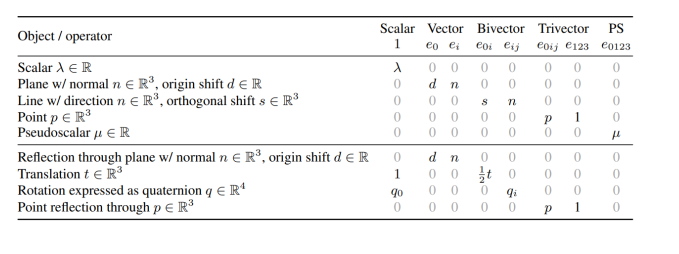  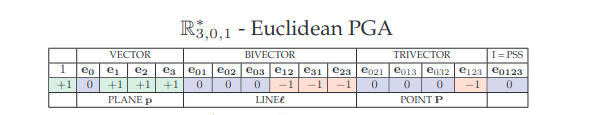